## NVIDIA Home assignment

### Notebook structure:
- Part 1 - EDA
- Part 2 - Models testing and evaluation

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import csv
import ast
from itertools import combinations

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from catboost import MetricVisualizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

## Part 1 - EDA

In [2]:
df = pd.read_feather('jr1966705-assignment-master/home_assignment.feather')
df = df.replace({'nan':None, '':None})
target = 'TLJYWBE'
print(f'data shape = {df.shape}')

data shape = (726288, 881)


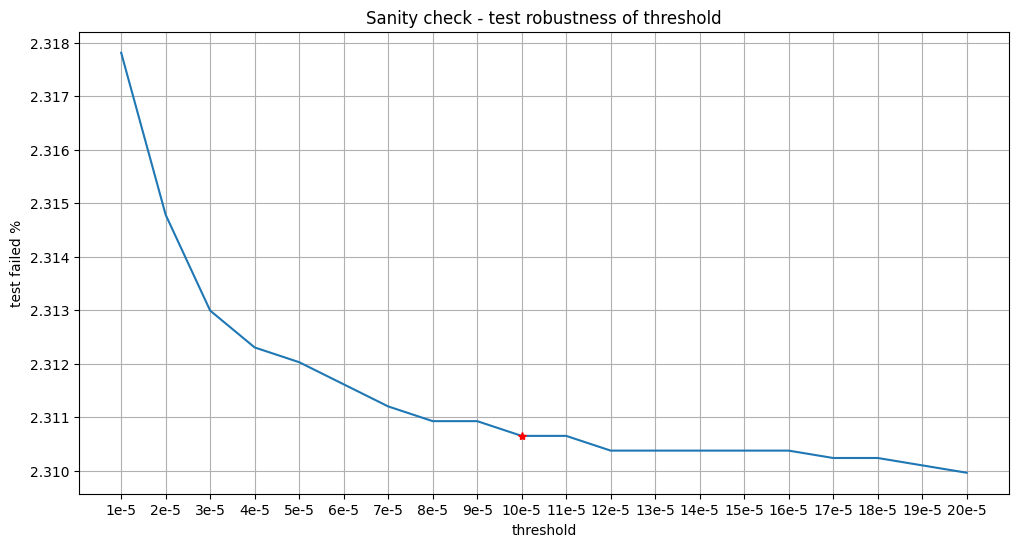

In [3]:
# Sanity check for the threshold
x = []
y = []
for i in range(1,21):
    df['test'] = (df[target] < i*1e-5).astype(int)
    target_counts = df.test.value_counts()
    x.append(i*1e-5)
    y.append(target_counts[0] * 100 / df.shape[0])

df = df.drop(columns=['test'])

original_threshold_index = np.where(np.array(x) == 10e-5)[0][0]
fig = plt.figure(figsize=(12, 6))
plt.plot(x, y)
plt.plot(x[original_threshold_index], y[original_threshold_index], 'r*')
plt.title('Sanity check - test robustness of threshold')
plt.xlabel('threshold')
plt.ylabel('test failed %')
plt.xticks(x, labels = [f'{i}e-5' for i in range(1, 21)])
plt.grid()
plt.show()

The change is minor, hence the given threshold is robustst

In [4]:
# Transform the target to binary label - in order to use a classification model
df['binary_target'] = (df[target] < 10e-5).astype(int)

In [5]:
# Remove for duplicated rows 
df.drop_duplicates(inplace = True)
print(f'data shape after removing duplicated rows = {df.shape}')

# Get target statistics
target_counts = df.binary_target.value_counts()
print(target_counts)

print(f'\n{target_counts[1] * 100 / df.shape[0]:.2f}% out of the data are tests that passed')
print(f'{target_counts[0] * 100 / df.shape[0]:.2f}% out of the data are tests that failed')

data shape after removing duplicated rows = (726288, 882)
binary_target
1    709506
0     16782
Name: count, dtype: int64

97.69% out of the data are tests that passed
2.31% out of the data are tests that failed


In [6]:
# Remove null columns
df.dropna(axis=1, how='all', inplace = True)
print(f'data shape after removing null columns = {df.shape}')

# Remove coulmns with more than 90% of valid data and single value
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1 and df[col].count() >= df.shape[0]*0.9] #explain
df.drop(columns = cols_to_drop, inplace = True)
print(f'data shape after removing columns with less than 10% nulls and single value = {df.shape}')

data shape after removing null columns = (726288, 861)
data shape after removing columns with less than 10% nulls and single value = (726288, 806)


In [7]:
# Given we have 2.31% of false in our data we want to check columns with 10% of the data or less for their target statistics, 
# if they follow about the same statistics as all the data they are unrelevant, if they have larger false percentage they might be good indicators
non_drop_threshold = 5
importance_threshold = 10
min_num_values = np.floor(df.shape[0]*0.005)
max_min_num_values = np.floor(df.shape[0]*0.1)
cols_to_drop = []
important_columns = []

counter = 0
for col in df.columns:
    if np.sum(df[col].count()) <= min_num_values:
        cols_to_drop.append(col)
    elif np.sum(df[col].count()) <= max_min_num_values:
        counter += 1
        temp_df = df.loc[df[col].notna(), ['binary_target']]
        temp_target_counts = temp_df.binary_target.value_counts()
        if temp_df['binary_target'].nunique() == 1:
            if 1 in temp_target_counts.index:
                cols_to_drop.append(col)
            else: 
                important_columns.append(col)
        else:
            false_percentage = temp_target_counts[0] * 100 / temp_df.shape[0]
            if false_percentage < non_drop_threshold:
                cols_to_drop.append(col)
            elif false_percentage >= importance_threshold:
                important_columns.append(col)
        
print(f'Out of {counter} columns with no more 0.5% and less than 10% non null values, {len(important_columns)} has significant higher value of false than in the entire dataset')

df.drop(columns = cols_to_drop, inplace = True)
print(f'data shape after removing columns with no more than 10% of valid observations and no higher percentage of false than the whole data= {df.shape}')

Out of 49 columns with no more 0.5% and less than 10% non null values, 38 has significant higher value of false than in the entire dataset
data shape after removing columns with no more than 10% of valid observations and no higher percentage of false than the whole data= (726288, 777)


In [8]:
important_columns_df = df.loc[:, important_columns]
important_columns_df.dropna(axis = 0, inplace=True)
important_columns_df.shape
corr = important_columns_df.select_dtypes(include=np.number).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='RdBu_r', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color of NaNs: grey
 .format(precision=2))

,PCIXTYP,FZHCPXN,ABKUZXQ,TNLTITB,WHWNSMK,OELGKKQ,ZQMONHC,AJOFIZJ,VXQLENI,HTTHEYH,FBDGIUT,VLOHNYE,KAHHGFH,MOYGMAB,YXRYJNT,TKXCHYD,TWTFEPM,ZBSCEOT,FBTIPCA,YLYAAGH,CYGFXWC,AHMUWMD
PCIXTYP,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FZHCPXN,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ABKUZXQ,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
TNLTITB,-0.11,-0.11,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
WHWNSMK,0.29,0.30,0.28,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OELGKKQ,0.48,0.49,0.47,-0.04,0.89,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
ZQMONHC,0.00,0.01,-0.00,-0.02,0.15,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AJOFIZJ,0.00,0.01,-0.00,-0.02,0.15,-0.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
VXQLENI,0.00,0.00,-0.00,-0.01,0.08,-0.00,0.51,0.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
HTTHEYH,-0.01,-0.01,-0.01,0.99,0.03,0.01,-0.02,-0.02,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [9]:
correlared_cols_to_drop = [column for column in corr.columns if any(abs(corr[column]) > 0.85)]
important_columns = [col for col in important_columns if col not in correlared_cols_to_drop]

#Further checks here - check for correlation in binary coulmns using jaccard score for example

In [10]:
min_num_values = np.floor(df.shape[0]*0.02)
cols_to_drop = [col for col in df.columns if np.sum(df[col].count()) <= min_num_values]
df.drop(columns = correlared_cols_to_drop + cols_to_drop, inplace = True)
print(f'data shape after removing columns with no more than {min_num_values} observations = {df.shape}')

data shape after removing columns with no more than 14525.0 observations = (726288, 739)


In [11]:
# Get list of numerical, categorial and non-numerical columns
# asserting categorical is at most 200 categories - can be different products, countries, etc
max_num_categories = 200
indicators = [col for col in df.columns if (df[col].nunique() == 1)]
binary_columns = [col for col in df.columns if (df[col].nunique() == 2)]
categorical_columns = [col for col in df.columns
                       if col not in binary_columns 
                       and col not in indicators 
                       and df[col].nunique() < max_num_categories]
non_numerical_columns =  [col for col in df.select_dtypes(exclude=np.number).columns 
                          if col not in binary_columns 
                          and col not in indicators 
                          and col not in categorical_columns]
numerical_columns =  [col for col in df.select_dtypes(include=np.number).columns 
                      if col not in binary_columns 
                      and col not in indicators 
                      and col not in categorical_columns]

binary_columns.remove('binary_target')

# Sanity check
print(len(indicators) + len(numerical_columns) + len(binary_columns) + len(categorical_columns) + len(non_numerical_columns) == df.shape[1] - 1)

True


In [12]:
print(f'num of single value columns: {len(indicators)}\n\
num of binary columns: {len(binary_columns)}\n\
num of categorical columns: { len(categorical_columns)}\n\
num of numerical columns: {len(numerical_columns)}\n\
num of non munerical columns: {len(non_numerical_columns)}')

num of single value columns: 8
num of binary columns: 15
num of categorical columns: 447
num of numerical columns: 264
num of non munerical columns: 4


In [13]:
# Single value usually doesn't give information, only if correlated to the target
for col in indicators:
    print(f'{col} has {np.sum(df[col].isna())*100/df.shape[0]:.2f}% nulls')
    print(f'percentage of false: ', round(df.loc[df[col].notna(), 'binary_target'].value_counts()[0]*100/df.loc[df[col].notna(), :].shape[0], 2))

OJSWUAF has 81.19% nulls
percentage of false:  2.49
EBEXNTO has 81.19% nulls
percentage of false:  2.49
FIGZKCY has 87.00% nulls
percentage of false:  1.12
FYWFJXP has 81.19% nulls
percentage of false:  2.49
LYCIQTI has 87.15% nulls
percentage of false:  1.11
JEQWBOK has 81.19% nulls
percentage of false:  2.49
TGXFVBT has 81.19% nulls
percentage of false:  2.49
WCYWJXK has 81.19% nulls
percentage of false:  2.49


In here we can see all single value columns probably contributes nothing since the target statistics are mostly kept and those probably are missing labels due to some failure in the data pipeline

In [14]:
df.drop(columns = indicators, inplace = True)
print(f'data shape after removing single value columns keeping target statistics = {df.shape}')

data shape after removing single value columns keeping target statistics = (726288, 731)


In [15]:
# Convert binary coulmns to boolians (except target)
for col in binary_columns:
    print(f'{col} has {np.sum(df[col].isna())*100/df.shape[0]:.2f}% nulls')
    print(f'percentage of false: ', round(df.loc[df[col].notna(), 'binary_target'].value_counts()[0]*100/df.loc[df[col].notna(), :].shape[0], 2))
    # Convert to boolean
    unique_values = df.loc[df[col].notna(), [col]][col].unique()
    print(unique_values)
    if unique_values[0] in ['True', 'False']:
        df[col] = df[col].apply(lambda x: x.strip().lower() == 'true' if x != None else None)
    else:
        replace_bool = {unique_values[0]:True, unique_values[1]:False}
        df[col] = df[col].replace(replace_bool)
    df[col] = df[col].astype('boolean')

LWFSOBB has 0.01% nulls
percentage of false:  2.31
['False' 'True']
WSTYRNH has 0.01% nulls
percentage of false:  2.31
['True' 'False']
IJOSAYZ has 0.01% nulls
percentage of false:  2.31
['True' 'False']
GNJJUIH has 0.01% nulls
percentage of false:  2.31
[1. 0.]
MKVXAUF has 0.01% nulls
percentage of false:  2.31
[1. 0.]
HOAJWUR has 0.01% nulls
percentage of false:  2.31
[1. 0.]
NJFNKOX has 0.01% nulls
percentage of false:  2.31
[1. 0.]
IQOCYUU has 0.11% nulls
percentage of false:  2.2
[1. 0.]
KVOYKGE has 0.97% nulls
percentage of false:  1.36
['False' 'FALSE']
RNCEKOH has 0.97% nulls
percentage of false:  1.36
['False' 'FALSE']
UMIGGHZ has 0.97% nulls
percentage of false:  1.36
['True' 'TRUE']
ZHPRSBN has 0.97% nulls
percentage of false:  1.36
['True' 'TRUE']
XRUUCHW has 0.96% nulls
percentage of false:  1.36
[1. 0.]
BADESAP has 0.01% nulls
percentage of false:  2.31
[0.    0.001]
QHIQJKY has 0.00% nulls
percentage of false:  2.31
[0.    0.001]


In [16]:
# Check non numerical columns values
for col in non_numerical_columns:
    print(f'{col} has {np.sum(df[col].isna())*100/df.shape[0]:.2f}% nulls')
    print(f'percentage of false: ', round(df.loc[df[col].notna(), 'binary_target'].value_counts()[0]*100/df.loc[df[col].notna(), :].shape[0], 2))
    unique_values = df.loc[df[col].notna(), [col]][col].unique()
    print(unique_values)

FFJOGRA has 0.98% nulls
percentage of false:  1.34
['574.8385' '608.5662' '583.2842' ... '740.3422' '718.8211' '715.4473']
MSAHYEA has 0.97% nulls
percentage of false:  1.36
['3485776.0' '2745188.0' '4307909.0' ... '483667.0' '552859.0' '348814.0']
DJANPLY has 0.97% nulls
percentage of false:  1.36
['2308558.0' '1866318.0' '2956375.0' ... '113480.0' '61845.0' '159936.0']
YCYSGLG has 0.03% nulls
percentage of false:  2.28
['-0.4370984' '-0.4040253' '-0.4556224' ... '-0.5272692' '-0.609935'
 '-0.5400347']


In [17]:
# Given the above results these columns are actually numerical - converted below
for col in non_numerical_columns:
    df[col] = df[col].replace({'-∞': -np.inf})
    df[col] = pd.to_numeric(df[col])

numerical_columns = numerical_columns + non_numerical_columns

In [18]:
# Check type of categorical columns
categorical_dtypes = []
for col in categorical_columns:
    categorical_dtypes.append(df[col].dtypes)    

categorical_dtypes = np.array(categorical_dtypes)
unique_dtypes = np.unique(categorical_dtypes)
print(unique_dtypes)

[dtype('int64') dtype('float64') dtype('O')]


In [19]:
# find categorical non numeric columns
indices = np.where(categorical_dtypes == unique_dtypes[2])[0]
categorical_non_numeric = [categorical_columns[i] for i in indices]

In [20]:
for col in categorical_non_numeric:
    print(f'{col} has {np.sum(df[col].isna())*100/df.shape[0]:.2f}% nulls')
    print(f'percentage of false: ', round(df.loc[df[col].notna(), 'binary_target'].value_counts()[0]*100/df.loc[df[col].notna(), :].shape[0], 2))
    unique_values = df.loc[df[col].notna(), [col]][col].unique()
    print(unique_values)

VZOZKWX has 0.96% nulls
percentage of false:  1.36
['22.86719' '23.75' '24.25' '24.36719' '23.61719' '24.11719' '24.75'
 '23.86719' '24.0' '25.11719' '24.86719' '24.5' '23.5' '24.61719' '25.25'
 '23.11719' '23.25' '25.0' '23.0' '23.36719' '25.61719' '22.5' '22.11719'
 '22.36719' '22.75' '22.0' '22.25' '21.86719' '22.61719' '21.61719'
 '25.36719' '25.5' '21.75' '21.5' '25.75' '20.75' '25.86719' '18.86719'
 '17.75' '17.61719' '19.86719' '0.0' '21.36719' '18.36719' '21.0' '20.0'
 '19.61719' '21.25' '21.11719' '20.25' '20.86719' '19.36719' '19.75'
 '17.36719' '17.25' '18.25' '19.11719' '20.61719' '17.11719' '19.5'
 '18.75' '20.5' '20.11719' '20.36719' '24' '23' '18.5' '18.61719'
 '49.99609' '255.9961' '17.0']
VRNGUZU has 0.03% nulls
percentage of false:  2.28
['9.334' '9.177' '9.474' '9.562' '9.631' '9.527' '9.387' '9.299' '9.194'
 '9.107' '9.509' '9.439' '9.229' '9.055' '9.317' '9.492' '9.072' '9.212'
 '9.911' '9.754' '9.701' '9.981' '9.16' '9.352' '9.282' '8.792' '9.247'
 '9.264' '9.142'

In [21]:
# Given the above results these columns are actually numerical - converted below
for col in categorical_non_numeric:
    df[col] = pd.to_numeric(df[col])

# Senity Check - type of categorical columns
categorical_dtypes = []
for col in categorical_columns:
    categorical_dtypes.append(df[col].dtypes)    

categorical_dtypes = np.array(categorical_dtypes)
unique_dtypes = np.unique(categorical_dtypes)
print(unique_dtypes)

[dtype('int64') dtype('float64')]


In [22]:
# To perform analysis, due to lack of computational resources, I sample the data uniformly
num_samples = 100000
sampled_df = df.sample(num_samples, random_state = 3).reset_index(drop = True)
print(f'sampled {num_samples * 100 / df.shape[0]:.2f}% of the data')

sampled 13.77% of the data


In [23]:
# Check to see target statistics are kept
target_counts_sampled = sampled_df.binary_target.value_counts()
print(target_counts_sampled)

print(f'\n{target_counts_sampled[1] * 100 / sampled_df.shape[0]:.2f}% out of the sampled data are tests that passed')

binary_target
1    97669
0     2331
Name: count, dtype: int64

97.67% out of the sampled data are tests that passed


#### Switch to work with SQL DB to deal with the size of the data

In [24]:
sampled_df.to_csv('sampled_NVDA_data.csv', index = False)

In [25]:
def dataType(val, current_type):
    try:
        # Evaluates numbers to an appropriate type, and strings an error
        t = ast.literal_eval(val)
    except ValueError:
        return 'varchar'
    except SyntaxError:
        return 'varchar'
    if type(t) in [int, float]:
        if (type(t) is int) and current_type not in ['float', 'varchar']:
           # Use smallest possible int type
            if (-32768 < t < 32767) and current_type not in ['int', 'bigint']:
               return 'smallint'
            elif (-2147483648 < t < 2147483647) and current_type not in ['bigint']:
               return 'int'
            else:
               return 'bigint'
        if type(t) is float and current_type not in ['varchar']:
           return 'decimal'
    else:
        return 'varchar'

In [26]:
# Create sql table statment for the dataset
f = open('sampled_NVDA_data.csv', 'r')
reader = csv.reader(f)

longest, headers, type_list = [], [], []
for row in reader:
    if len(headers) == 0:
        headers = row
        for col in row:
            longest.append(0)
            type_list.append('')
    else:
        for i in range(len(row)):
            if row[i] == '':
                pass
            else:
                var_type = dataType(row[i], type_list[i])
                type_list[i] = var_type
            if len(row[i]) > longest[i]:
                longest[i] = len(row[i])
f.close()

for i in range(len(type_list)):
    if type_list[i] == '':
        type_list[i] = 'varchar'

In [27]:
statement = 'CREATE TABLE IF NOT EXISTS NVDA_data ('

for i in range(len(headers)):
    if type_list[i] == 'varchar':
        statement = (statement + '\n{} varchar({}),').format(headers[i], str(longest[i]))
    else:
        statement = (statement + '\n' + '{} {}' + ',').format(headers[i], type_list[i])

statement = statement[:-1] + ');'

In [28]:
statement

'CREATE TABLE IF NOT EXISTS NVDA_data (\nHKTLMYY smallint,\nIJEXXXL decimal,\nKVNLYTZ decimal,\nADOIOYN decimal,\nGPCKISJ decimal,\nBFYTKKS decimal,\nHNJMSWN decimal,\nTDMCRGU decimal,\nHNDGNRG decimal,\nHFHITLP decimal,\nRFLFROK decimal,\nOCFKMIL decimal,\nLIXROQF decimal,\nBMDJBLU decimal,\nJORKKSF decimal,\nVEUJYWN decimal,\nSOLTBDE decimal,\nKGJACPV decimal,\nVPAZKWG decimal,\nLCFCVCB decimal,\nRRMMRAJ decimal,\nDAEPCOR decimal,\nHGHMTVH decimal,\nNUTXJCG decimal,\nXMVIFQS decimal,\nMWHYOSB decimal,\nHWKCDPO decimal,\nLKFNGDB decimal,\nEEGYIGX decimal,\nQJXZQSD decimal,\nQWVFRRZ decimal,\nEYILHOU decimal,\nJHQKHHL decimal,\nMIIVLBT decimal,\nQVOHUMP decimal,\nVCSGLFK decimal,\nLFVWFTF decimal,\nRCJGZLT decimal,\nCWWUCQG decimal,\nTXEIVQY decimal,\nRMSJZUV decimal,\nADXRLFT decimal,\nYBBDEJH decimal,\nKGPPPLD decimal,\nGGTSHYD decimal,\nLCXZSFV decimal,\nREQAQFJ decimal,\nEBCCQTL decimal,\nPOPBDDN decimal,\nMDVCOCJ decimal,\nMYUPDRP decimal,\nOLSNQUS decimal,\nESUYYIB decimal,\nNYRK

In [29]:
conn = sqlite3.connect("sampled_NVDA_data.db")

cursor = conn.cursor()

cursor.execute(statement)
conn.commit()

sampled_df.to_sql('sampled_NVDA_data', conn, if_exists='replace', chunksize=100)

100000

In [30]:
for col in df.columns:
    query = f"UPDATE sampled_NVDA_data\
            SET {col} = NULL\
            WHERE {col} == 'nan' OR {col} == '';"

    cursor.execute(query)

In [31]:
# Remove outliers from numerical columns (remove values using IQR - bigger than 75th percentile+1.5*IQR, smaller than 25th perecentile - 1.5*IQR)
for col in numerical_columns:
        if col not in important_columns:
                query = f'SELECT MAX(ntiles.{col})\
                        FROM (\
                                SELECT {col}, \
                                NTILE(4) OVER(\
                                ORDER BY {col}) AS ntile\
                                FROM sampled_NVDA_data\
                                WHERE {col} IS NOT NULL) AS ntiles\
                        WHERE ntile == 1;'
                                

                cursor.execute(query)
                percentile_25 = cursor.fetchall()[0][0]

                query = f'SELECT MAX(ntiles.{col})\
                        FROM (\
                                SELECT {col}, \
                                NTILE(4) OVER(\
                                ORDER BY {col}) AS ntile\
                                FROM sampled_NVDA_data\
                                WHERE {col} IS NOT NULL) AS ntiles\
                        WHERE ntile == 3;'

                cursor.execute(query)
                percentile_75 = cursor.fetchall()[0][0]

                IQR = percentile_75 - percentile_25

                query = f"UPDATE sampled_NVDA_data\
                        SET {col} = NULL\
                        WHERE {col} > {percentile_75 + 1.5*IQR} \
                                OR {col} < {percentile_25 - 1.5*IQR};"
                cursor.execute(query)

In [32]:
# # Check for correlations in the numerical data - Tried, it takes too long to finish
# with open('correlations.csv', 'w') as f:
#     f.write('index, col_1, col_2, corr_val\n')
#     for i, (col_a, col_b) in enumerate(combinations(numerical_columns, 2)):

#         query = f'SELECT AVG( ({col_a} - avg_x) * ({col_b} - avg_y) ) * AVG( ({col_a} - avg_x) * ({col_b} - avg_y) )/(var_x*var_y) as R2\
#                 FROM sampled_NVDA_data, (SELECT\
#                     avg_x,\
#                     avg_y,\
#                     AVG(({col_a} - avg_x)*({col_a} - avg_x)) as var_x,\
#                     AVG(({col_b} - avg_y)*({col_b} - avg_y)) as var_y\
#                     from sampled_NVDA_data, (SELECT\
#                         AVG({col_a}) as avg_x,\
#                         AVG({col_b}) as avg_y\
#                         from sampled_NVDA_data)\
#                     );'

#         cursor.execute(query)
#         for row in cursor.fetchall():
#             f.write(f'{i}, {col_a}, {col_b}, {row[0]}\n')

In [33]:
# Null imputation - fill null values with AVG col value for numerical columns
for col in numerical_columns:
        if col not in important_columns:
                query = f'SELECT AVG({col})\
                        FROM sampled_NVDA_data\
                        WHERE {col} IS NOT NULL;'                                

                cursor.execute(query)
                col_avg = cursor.fetchall()[0][0]
                col_avg = round(col_avg, 3)

                query = f"UPDATE sampled_NVDA_data\
                        SET {col} = {col_avg}\
                        WHERE {col} IS NULL;"
                cursor.execute(query)

In [34]:
# Null imputation - fill null values with common value for categorical columns
for col in categorical_columns + binary_columns:
    if col not in important_columns:
        query = f'SELECT {col}\
                FROM  (\
                        SELECT {col},\
                        COUNT({col}) as "count"\
                        FROM sampled_NVDA_data\
                        GROUP BY {col}\
                        ORDER BY "count" DESC)\
                        WHERE {col} IS NOT NULL\
                LIMIT 1;'
        
        cursor.execute(query)
        common_val = cursor.fetchall()[0][0]
        query = f"UPDATE sampled_NVDA_data\
                SET {col} = {common_val}\
                WHERE {col} IS NULL;"

        cursor.execute(query)

## Part 2 - Model Selection


In [37]:
query = "SELECT * FROM sampled_NVDA_data"
sampled_NVDA_data_clean = pd.read_sql(query, conn)

In [38]:
X = sampled_NVDA_data_clean.drop(columns=[target, 'binary_target'])
y = sampled_NVDA_data_clean.loc[:, 'binary_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [39]:
def calc_metrics(confusion_matrix):
    FP = confusion_matrix[0, 1]  
    FN = confusion_matrix[1, 0]  
    TP = confusion_matrix[1, 1]  
    TN = confusion_matrix[0, 0]  

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    return [FP, FN, TP, TN, TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]


In [40]:
def add_to_result_df(alg_name, confusion_matrix, columns, results_df):
    metrics = [alg_name] + calc_metrics(confusion_matrix)
    results_dict = {key: metrics[i] for i, key in enumerate(columns)}

    if results_df.empty:
        results_df = pd.DataFrame(results_dict, index = [0])

    else:
        results_df = pd.concat([results_df, pd.DataFrame(results_dict, index = [0])], ignore_index = True)

    return results_df

In [127]:
columns = ['Model type', 'FP', 'FN', 'TP', 'TN', 'recall', 'specificity', 'precision', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC']
results_df = pd.DataFrame(columns = columns)

In [128]:
pos_class_weight = 0.01 #should be optimized

### Lightgbm

In [129]:
lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42, scale_pos_weight=pos_class_weight)
lgb_model.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)], verbose=20, eval_metric='logloss')

[20]	training's binary_logloss: 0.0590077	valid_0's binary_logloss: 0.0609983
[40]	training's binary_logloss: 0.0429766	valid_0's binary_logloss: 0.049033
[60]	training's binary_logloss: 0.0251076	valid_0's binary_logloss: 0.0338929
[80]	training's binary_logloss: 0.0137071	valid_0's binary_logloss: 0.0232321
[100]	training's binary_logloss: 0.00768375	valid_0's binary_logloss: 0.0179554


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42,
               scale_pos_weight=0.01)

<Axes: title={'center': 'Feature importance - Lightgbm'}, xlabel='Feature importance', ylabel='Features'>

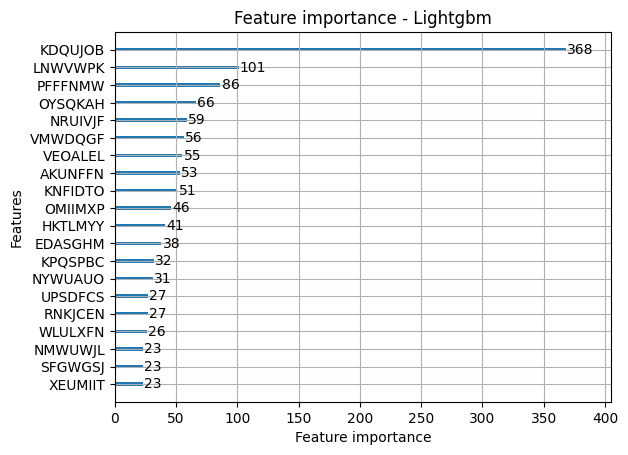

In [130]:
lgb.plot_importance(lgb_model, max_num_features = 20, title = 'Feature importance - Lightgbm')

<Axes: title={'center': ' Metric During Training - lightGBM'}, xlabel='Iterations', ylabel='binary_logloss'>

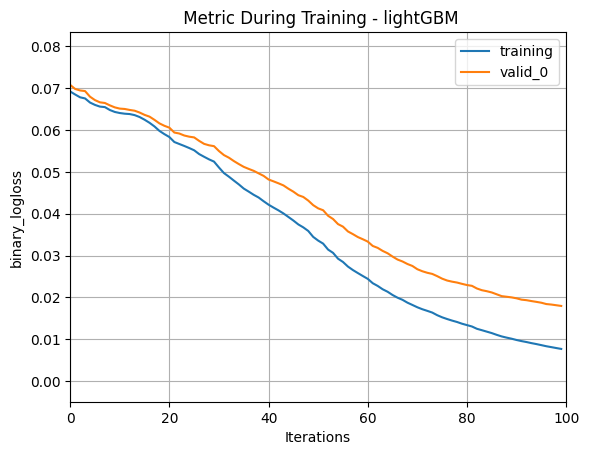

In [131]:
lgb.plot_metric(lgb_model, title=' Metric During Training - lightGBM')

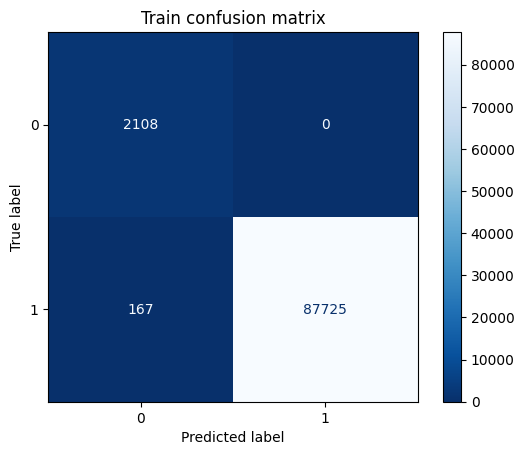

In [132]:
confusion_matrix = metrics.confusion_matrix(y_train, lgb_model.predict(X_train))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Train confusion matrix')
plt.show()

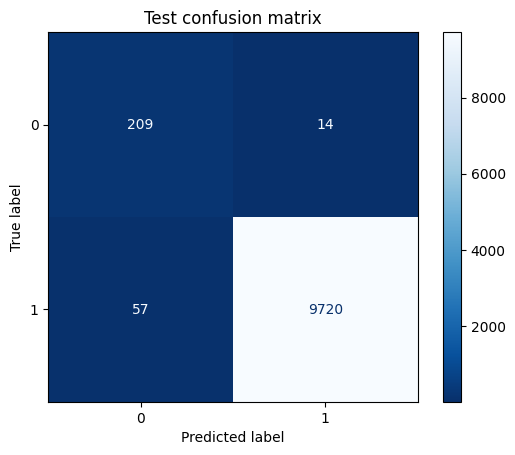

In [133]:
confusion_matrix = metrics.confusion_matrix(y_test, lgb_model.predict(X_test))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Test confusion matrix')
plt.show()

In [134]:
results_df = add_to_result_df('lightGBM', confusion_matrix, columns, results_df)
results_df

,Model type,FP,FN,TP,TN,recall,specificity,precision,NPV,FPR,FNR,FDR,ACC
0,lightGBM,14,57,9720,209,0.99417,0.93722,0.998562,0.785714,0.06278,0.00583,0.001438,0.9929


### XGBoost

In [135]:
xgb_model = xgb.XGBClassifier(loss_function='Logloss', scale_pos_weight=pos_class_weight)
xgb_model.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)], verbose=20)

[22:06:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "loss_function" } are not used.

[0]	validation_0-logloss:0.48452	validation_1-logloss:0.48501
[20]	validation_0-logloss:0.07332	validation_1-logloss:0.07090
[40]	validation_0-logloss:0.03840	validation_1-logloss:0.03414
[60]	validation_0-logloss:0.02754	validation_1-logloss:0.02185
[80]	validation_0-logloss:0.02314	validation_1-logloss:0.01663
[99]	validation_0-logloss:0.02016	validation_1-logloss:0.01319


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              loss_function='Logloss', max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

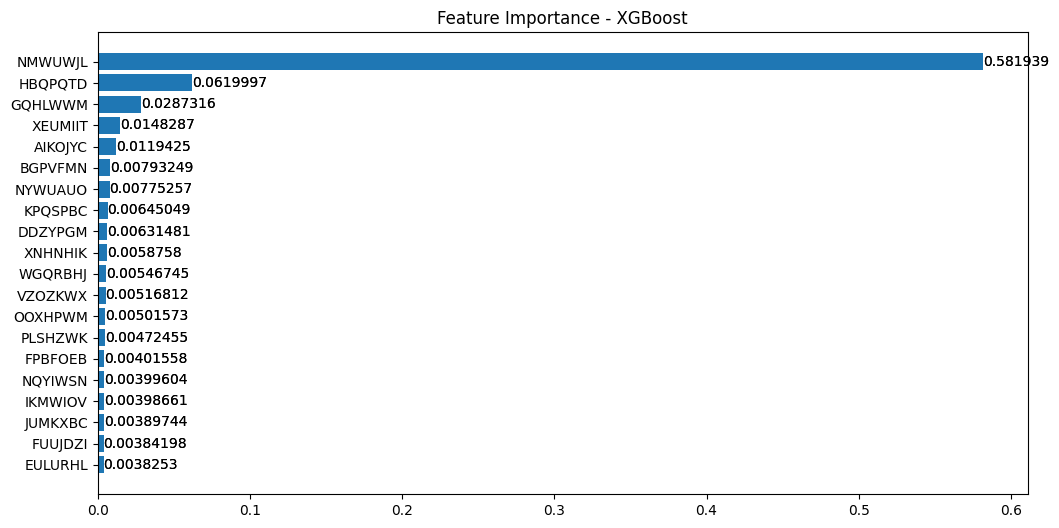

In [136]:
max_num_features = 20
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(max_num_features), feature_importance[sorted_idx[-max_num_features:]], align='center')
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.yticks(range(max_num_features), np.array(X_test.columns)[sorted_idx[-max_num_features:]])
plt.title('Feature Importance - XGBoost');
plt.show(fig)

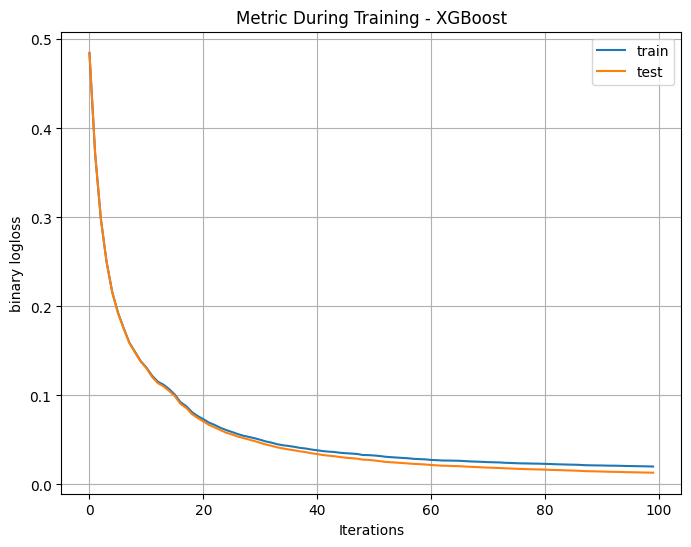

In [137]:
results = xgb_model.evals_result()
# plot learning curves
fig = plt.figure(figsize=(8, 6))
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.title('Metric During Training - XGBoost')
plt.xlabel('Iterations')
plt.ylabel('binary logloss')
plt.grid()
plt.show()

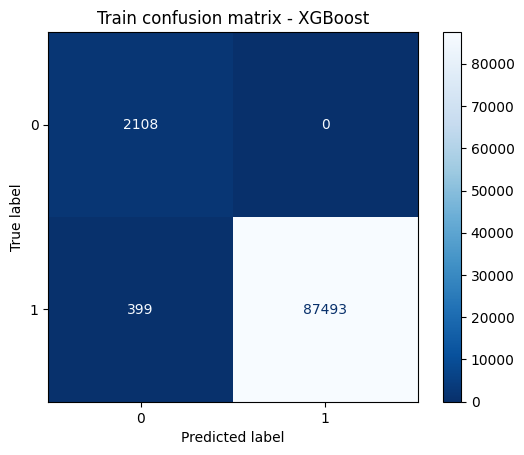

In [138]:
confusion_matrix = metrics.confusion_matrix(y_train, xgb_model.predict(X_train))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Train confusion matrix - XGBoost')
plt.show()

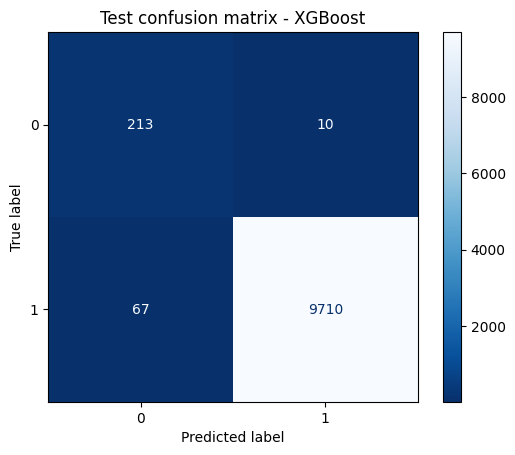

In [139]:
confusion_matrix = metrics.confusion_matrix(y_test, xgb_model.predict(X_test))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Test confusion matrix - XGBoost')
plt.show()

In [140]:
results_df = add_to_result_df('XGBoost', confusion_matrix, columns, results_df)
results_df

,Model type,FP,FN,TP,TN,recall,specificity,precision,NPV,FPR,FNR,FDR,ACC
0,lightGBM,14,57,9720,209,0.994170,0.937220,0.998562,0.785714,0.062780,0.005830,0.001438,0.9929
1,XGBoost,10,67,9710,213,0.993147,0.955157,0.998971,0.760714,0.044843,0.006853,0.001029,0.9923


### CatBoost

In [141]:
train_dataset = cb.Pool(X_train,
                     y_train,
                     weight=[pos_class_weight if a == 1 else 1 for a in y_train])
cb_model = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', train_dir='cb_model/')
cb_model.fit(train_dataset, eval_set=[(X_test,y_test),(X_train,y_train)], verbose=50, use_best_model = True)

Learning rate set to 0.096296
0:	learn: 0.9666747	test: 0.9065000	test1: 0.9070000	best: 0.9070000 (0)	total: 81ms	remaining: 1m 20s
50:	learn: 0.9835315	test: 0.9458000	test1: 0.9453444	best: 0.9453444 (50)	total: 3.52s	remaining: 1m 5s
100:	learn: 0.9898357	test: 0.9649000	test1: 0.9662667	best: 0.9662667 (100)	total: 6.39s	remaining: 56.8s
150:	learn: 0.9933678	test: 0.9751000	test1: 0.9779889	best: 0.9779889 (150)	total: 9.23s	remaining: 51.9s
200:	learn: 0.9947203	test: 0.9800000	test1: 0.9824778	best: 0.9824778 (199)	total: 11.8s	remaining: 46.7s
250:	learn: 0.9952794	test: 0.9818000	test1: 0.9843333	best: 0.9843333 (250)	total: 14.1s	remaining: 42s
300:	learn: 0.9962135	test: 0.9838000	test1: 0.9874333	best: 0.9874333 (300)	total: 16.5s	remaining: 38.4s
350:	learn: 0.9969802	test: 0.9857000	test1: 0.9899778	best: 0.9899778 (350)	total: 19.1s	remaining: 35.4s
400:	learn: 0.9973150	test: 0.9871000	test1: 0.9910889	best: 0.9910889 (399)	total: 21.8s	remaining: 32.6s
450:	learn: 0.9

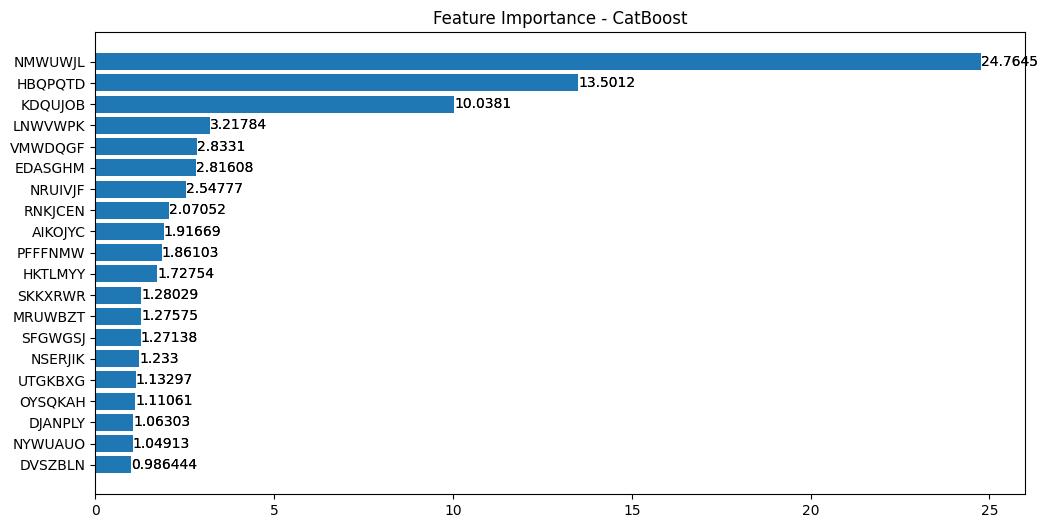

In [142]:
max_num_features = 20
feature_importance = cb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(max_num_features), feature_importance[sorted_idx[-max_num_features:]], align='center')
ax.bar_label(bars)
for bars in ax.containers:
    ax.bar_label(bars)
plt.yticks(range(max_num_features), np.array(X_test.columns)[sorted_idx[-max_num_features:]])
plt.title('Feature Importance - CatBoost');
plt.show(fig)

In [143]:
widget = MetricVisualizer(['cb_model'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

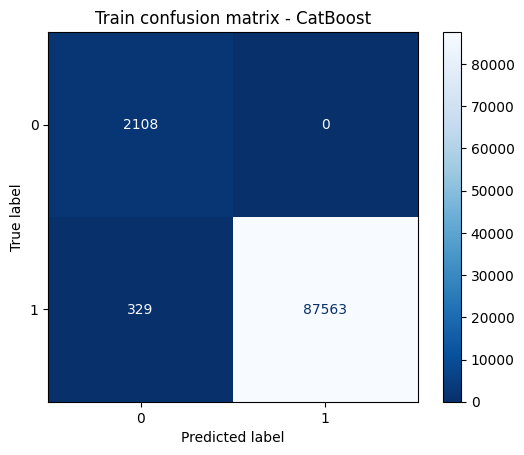

In [144]:
confusion_matrix = metrics.confusion_matrix(y_train, cb_model.predict(X_train))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Train confusion matrix - CatBoost')
plt.show()

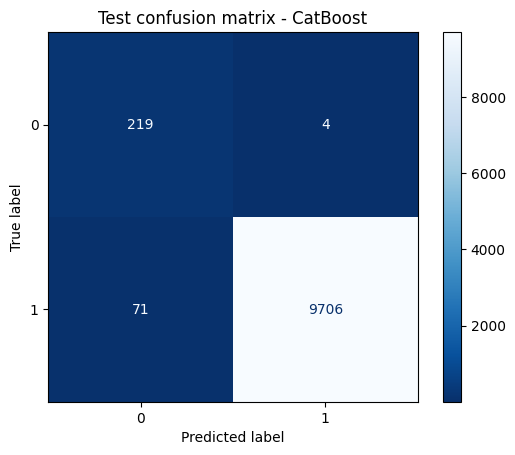

In [145]:
confusion_matrix = metrics.confusion_matrix(y_test, cb_model.predict(X_test))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot(cmap='Blues_r')
plt.title('Test confusion matrix - CatBoost')
plt.show()

In [146]:
results_df = add_to_result_df('CatBoost', confusion_matrix, columns, results_df)
results_df

,Model type,FP,FN,TP,TN,recall,specificity,precision,NPV,FPR,FNR,FDR,ACC
0,lightGBM,14,57,9720,209,0.994170,0.937220,0.998562,0.785714,0.062780,0.005830,0.001438,0.9929
1,XGBoost,10,67,9710,213,0.993147,0.955157,0.998971,0.760714,0.044843,0.006853,0.001029,0.9923
2,CatBoost,4,71,9706,219,0.992738,0.982063,0.999588,0.755172,0.017937,0.007262,0.000412,0.9925


Based on the result of the 3 models, CatBoost will probably be the best model to choose, since it had lowest FPR (assuming we preffer to have a good product not pass the test than a faulty product to pass the test)